# Construction of eulerian comparison dataframe
- from L2 filtered data and field interpolation
- create a vaex.dataframe where each row is a point of comparison: 
['id',
 'time',
 'lat',
 'lon',
 'u_drifter',
 'v_drifter',
 'u_geo_swot',
 'v_geo_swot',
 'u_var_swot',
 'v_var_swot',
 'u_geo_nadir',
 'v_geo_nadir',
 'u_var_nadir',
 'v_var_nadir']

#### Imports

In [1]:
import sys
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import scipy
import scipy.signal

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
import Drifters_processing


%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'
path_fields = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/fields_data'

path_save_data = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/drifters_scenes'
path_save_plots = '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024_07_05_scene_filtering'

## Data and utils

In [2]:
# L3 field data
ds_swot = xr.open_dataset(os.path.join(path_fields, 'field_L3SWOT.nc'))

# SVP Drifters
L2_dir = '/home/bouxdecl/Documents/data/DRIFTERS/L2'
FILES_SVP

['L2_svp_scripps_10min_lowess_30min_v0.nc',
 'L2_svp_ogs_1h_lowess_30min_v0.nc',
 'L2_svp_ogs_10min_lowess_30min_v0.nc',
 'L2_svp_shom_10min_lowess_30min_v0.nc',
 'L2_svp_scripps_1h_lowess_30min_v0.nc',
 'L2_svp_bcg_10min_lowess_30min_v0.nc']

## One trajectory processing

special traj : move around the swath

xr.open_dataset(os.path.join(L2_dir, file_svp30min[3])).isel(id=5).dropna(dim='time', how='any', subset=['u'])

xr.open_dataset(os.path.join(L2_dir, file_svp30min[3])).isel(id=18).dropna(dim='time', how='any', subset=['u'])

In [5]:
one_trajectory = open_one_traj(L2_dir, FILES_SVP[3], idx_id= 18, L3_cleaning=True, padd_swath=0.75)
one_trajectory

<xarray.Dataset>
Dimensions:  (time: 3893)
Coordinates:
    id       <U15 '300534062470440'
  * time     (time) datetime64[ns] 2023-03-31T17:00:00 ... 2023-07-09
    dt       float64 1.8e+03
Data variables:
    u        (time) float64 0.3207 0.3234 0.3279 ... -0.03271 -0.02475 -0.009841
    v        (time) float64 0.2303 0.2129 0.1973 0.1753 ... 0.1122 0.1068 0.1055
    lon      (time) float64 4.887 4.894 4.902 4.909 ... 5.0 5.0 4.999 4.999
    lat      (time) float64 42.27 42.27 42.27 42.27 ... 42.54 42.54 42.54 42.54
Attributes:
    traj_id:  file=L2_svp_shom_10min_lowess_30min_v0.nc ; idx_id=18

In [6]:
GAUSSIAN_STD = 6*3600

liss_lat = Drifters_processing.gaussian_filter(one_trajectory.lat, dt=one_trajectory.dt, gaussian_std=GAUSSIAN_STD)
liss_lon = Drifters_processing.gaussian_filter(one_trajectory.lon, dt=one_trajectory.dt, gaussian_std=GAUSSIAN_STD)

points_day = (one_trajectory.lon[::48], one_trajectory.lat[::48])


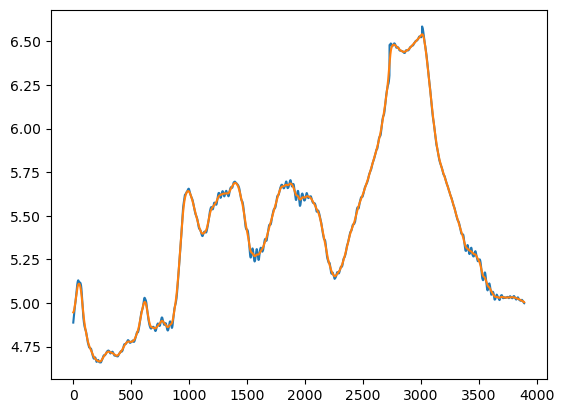

In [141]:
matplotlib.rcParams['figure.dpi'] = 100

dt = float(one_trajectory.time[1] - one_trajectory.time[0])*1e-9

plt.plot(one_trajectory.lon)
plt.plot(liss_lon)

/tmp/ipykernel_10160/3539379750.py:37: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  field = field.interp(time=time_ssh)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)


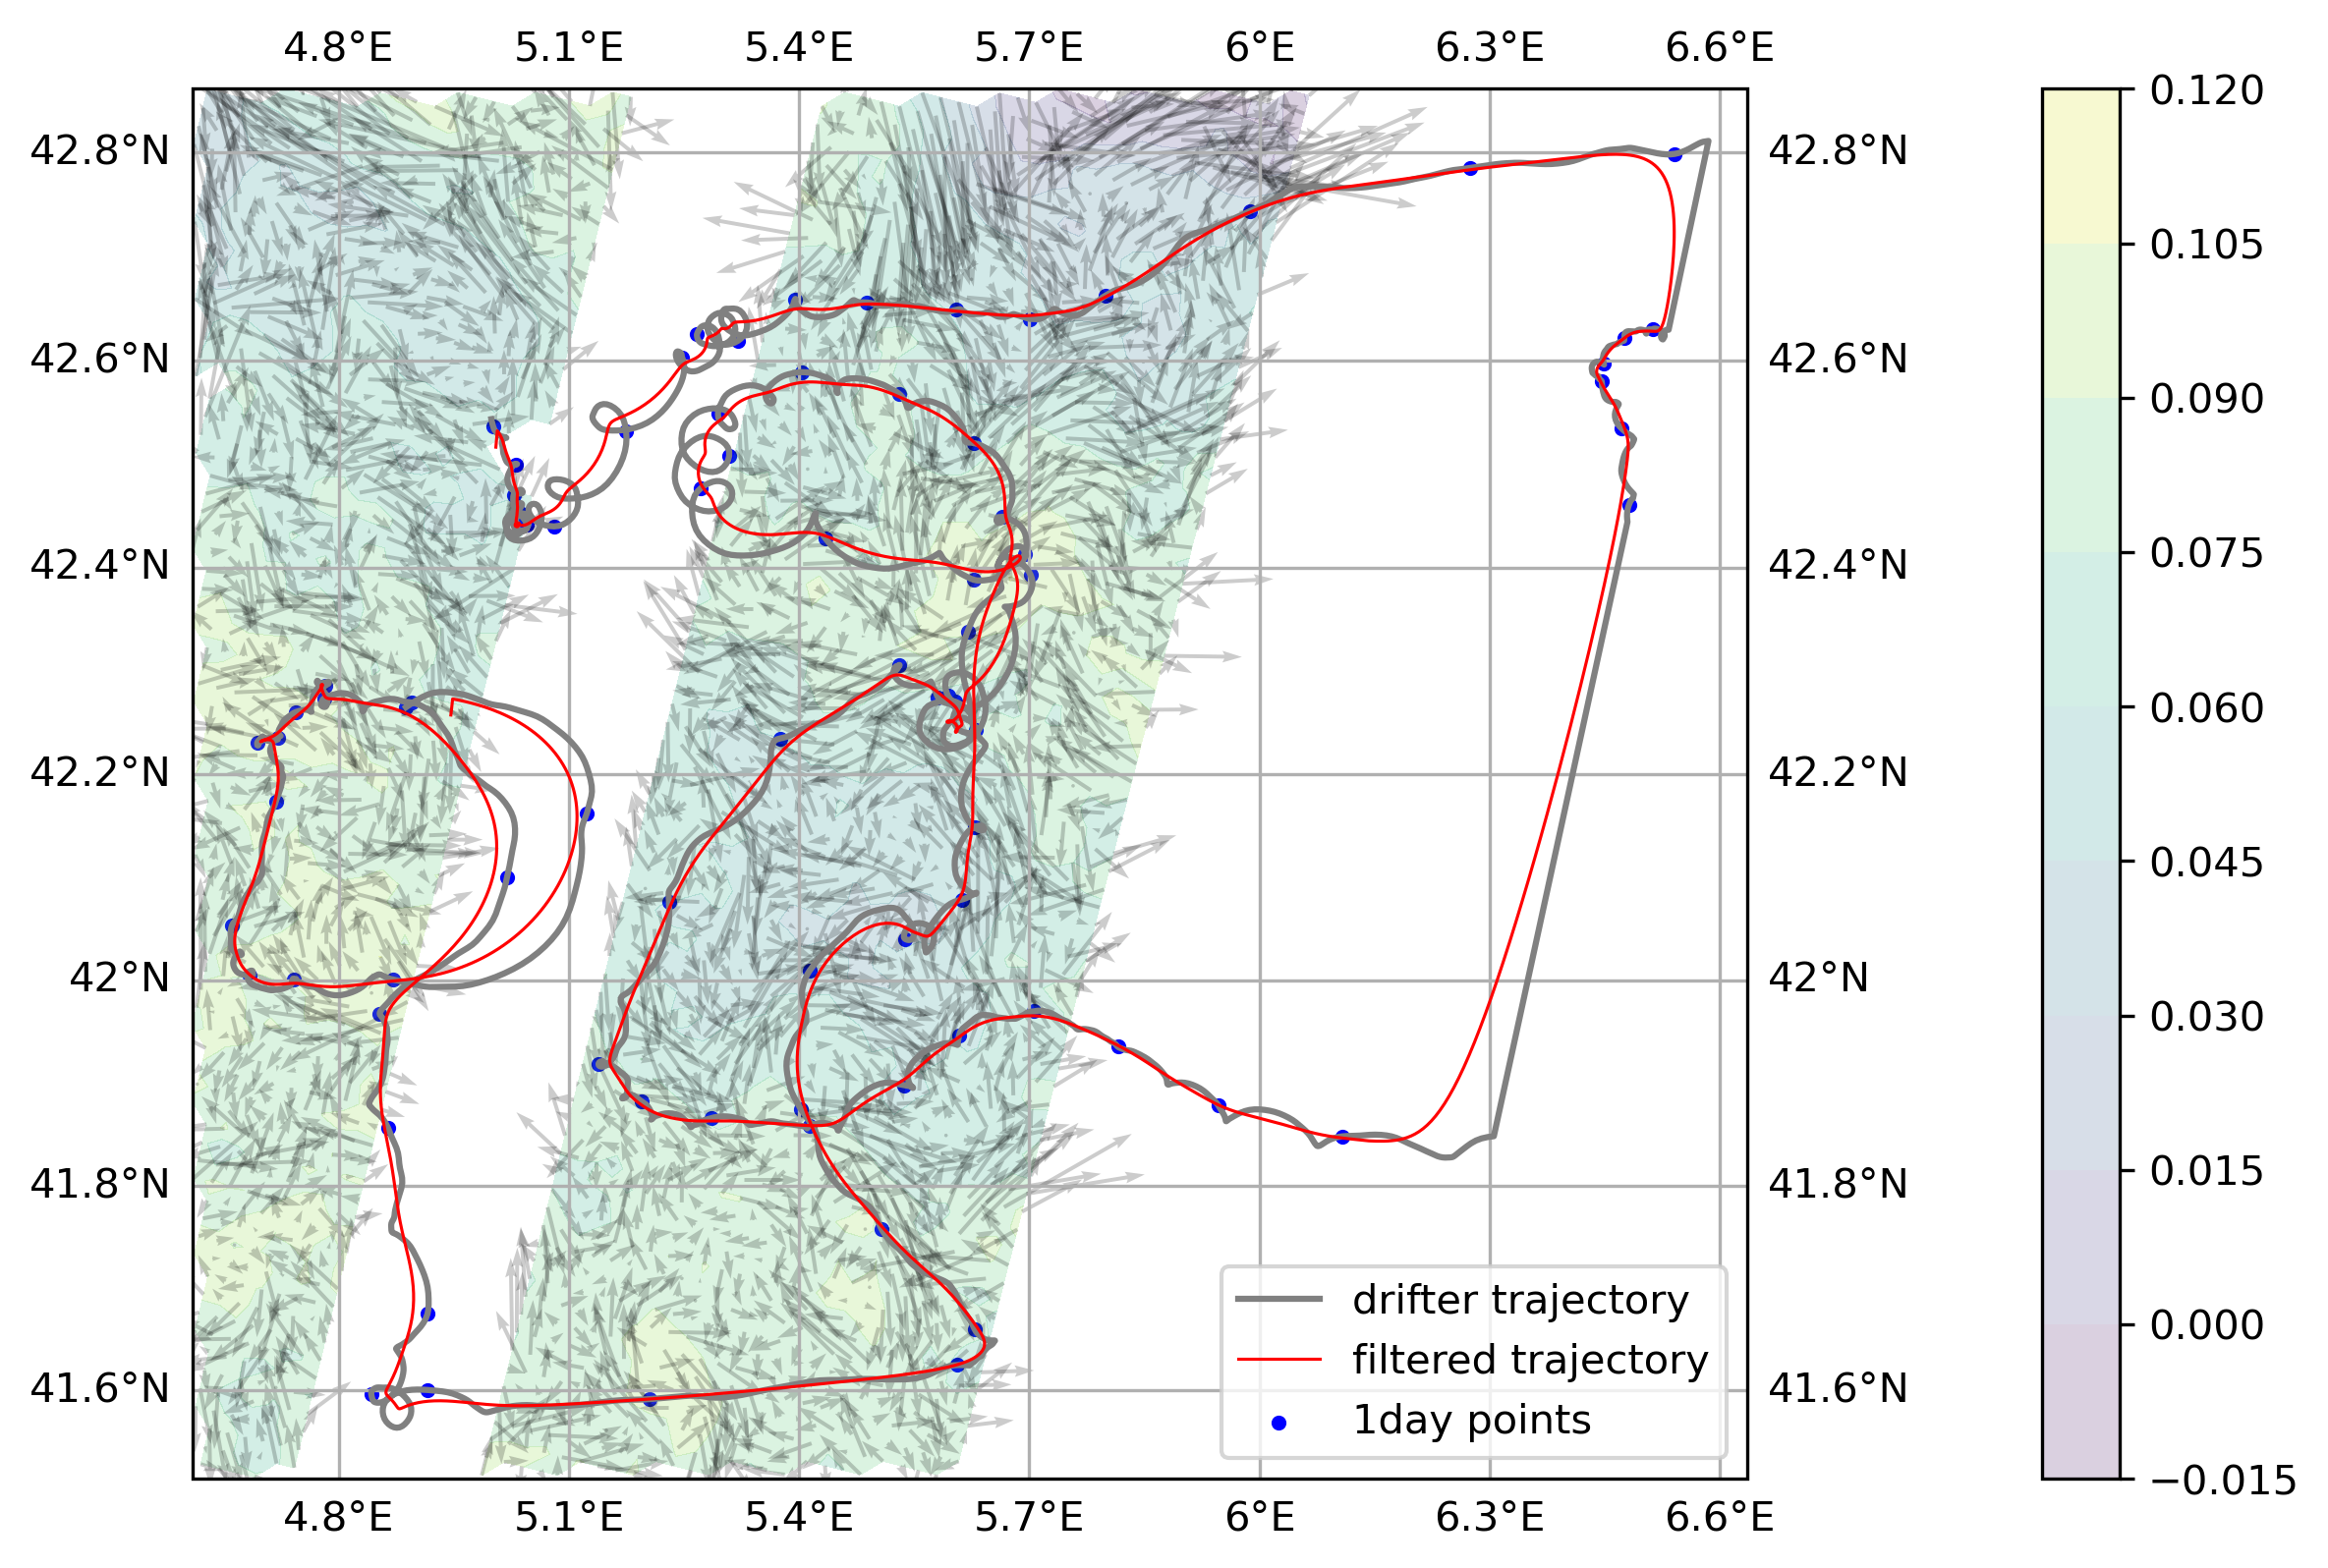

In [142]:

ds = one_trajectory

matplotlib.rcParams['figure.dpi'] = 300

plt.ion()
# Plot the trajectory with the velocity vectors AND fields vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)
scale=1.5e-5 *2
width=2.5e-3

padd = 0.05
bbox = (np.nanmin(ds.lon.values) -padd, np.nanmax(ds.lon.values) +padd, np.nanmin(ds.lat.values)-padd, np.nanmax(ds.lat.values)+padd ) 

ax.set_extent(bbox, crs=crs)

# trajectory
ax.plot(ds.lon, ds.lat,transform=crs, color='grey', label='drifter trajectory')

# filtered
ax.plot(liss_lon, liss_lat, transform=crs, color='red', lw=0.75, label='filtered trajectory')

#points day
ax.scatter(*points_day, transform=crs, color='b', s=7, label='1day points')


# ssh field
#time_ssh = get_mean_datetime(ds.time.values)
#time_ssh = np.nanmin(ds.time.values)
time_ssh = get_mean_datetime(ds.time.values)

field = restrain_domain(ds_swot, *bbox)
field = field.interp(time=time_ssh)
ssh_field = ax.contourf(field.longitude, field.latitude, field.ssh, transform=crs, alpha=0.2, label='SSH (swot)')


# Add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1, axes_class=plt.Axes)
cbar = plt.colorbar(ssh_field, cax=cax)

# add velocity field
ax.quiver(field.longitude.values, field.latitude.values, field.u_var.values, field.v_var.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)
#ax.quiver(field.longitude.values, field.latitude.values, field.u_geos.values, field.v_geos.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)


ax.legend()

###plt.savefig(os.path.join(path_save_plots, 'filtreddrifter_gaussian_6h.png'), bbox_inches='tight', dpi = 300)

### filter analysis

In [7]:
def welch(sig_list, name_list, dt, nfenetre = None, save=True):

    if nfenetre is None:
        nfenetre = len(sig_list[0]) //3

    fig, ax = plt.subplots()

    results = []
    for sig, lb in zip(sig_list, name_list):
        frequencies, psd = scipy.signal.welch(sig, fs=1/dt, nperseg = nfenetre, noverlap=nfenetre//4)
        ax.semilogy(frequencies, psd, label=lb)
        results.append((frequencies, psd))

    ax.axvline(1/(19*3600), c='black', ls='--', label='19h (99% filtering)')
    ax.axvline(1/(24*3600), c='grey', ls='--', label='24h (90% filtering)')
    ax.axvline(1/(48*3600), c='grey', ls='--', label='48h (50% filtering)')
    ax.axvline(1/(120*3600), c='grey', ls='--', label='120h (10% filtering)')

    xlim = 10**(-4)
    ax.set_xlim(-0.02*1e-4, 4e-5)
    ax.set_ylim(1e-3, 1e6)

    ax.set_title('PSD of the complex velocity (Welch\'s Method)')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (V^2/Hz)')
    ax.grid()
    ax.legend()

    # Set the x-axis to display in powers of ten
    formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    plt.show()

    if save:
        save_name = 'PSD'+ name_list[1] + '.png'
        plt.savefig(os.path.join(path_save_plots, save_name), bbox_inches='tight', dpi = 300)

    return results

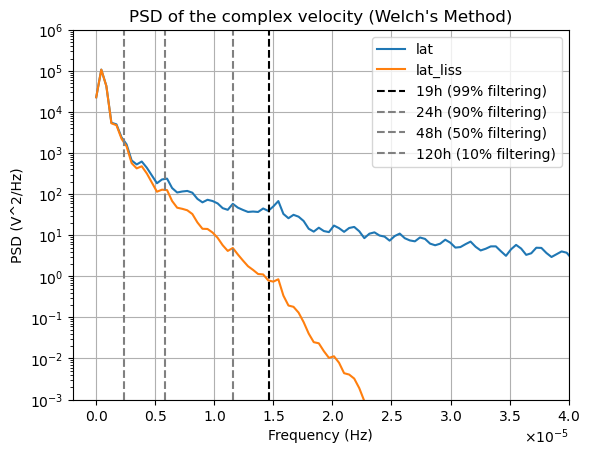

<Figure size 640x480 with 0 Axes>

In [8]:
(freq0, psd0), (freq, psd) = welch([one_trajectory.lat.values, liss_lat], ['lat', 'lat_liss'], dt=one_trajectory.dt.values)

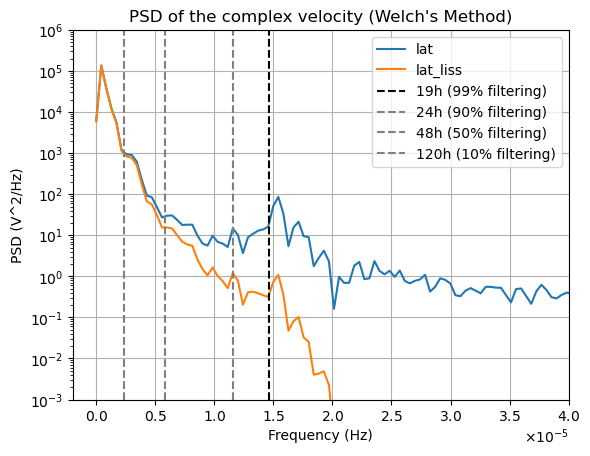

<Figure size 640x480 with 0 Axes>

In [9]:
(freq0, psd0), (freq, psd) = welch([one_trajectory.lon.values, liss_lon], ['lat', 'lat_liss'], dt=one_trajectory.dt.values)

In [10]:
ord = np.argsort(freq) 

freq = freq[ord]
psd = psd[ord]
psd0 = psd0[ord]

filter_fraction = psd/psd0

In [11]:
print('filtering at 19h:', np.interp(1/(19*3600), freq, filter_fraction))
print('filtering at 19h:', np.interp(1/(24*3600), freq, filter_fraction))
print('filtering at 19h:', np.interp(1/(36*3600), freq, filter_fraction))
print('filtering at 19h:', np.interp(1/(48*3600), freq, filter_fraction))
print('filtering at 19h:', np.interp(1/(72*3600), freq, filter_fraction))
print('filtering at 19h:', np.interp(1/(120*3600), freq, filter_fraction))

filtering at 19h: 0.018799252210088276
filtering at 19h: 0.08137375605967362
filtering at 19h: 0.32993911921864033
filtering at 19h: 0.5422170302328994
filtering at 19h: 0.778408048051711
filtering at 19h: 0.9229563169392594


In [22]:
def welch_cplx(sig_list, name_list, dt, nfenetre = None, save=True):

    if nfenetre is None:
        nfenetre = len(sig_list[0]) //3

    fig, ax = plt.subplots()

    results = []
    for sig, lb in zip(sig_list, name_list):
        frequencies, psd = scipy.signal.welch(sig, fs=1/dt, nperseg = nfenetre, noverlap=nfenetre//4)
        ax.semilogy(frequencies, psd, label=lb)
        results.append((frequencies, psd))

    #ax.axvline(1/(19*3600), c='black', ls='--', label='19h (99% filtering)')
    ax.axvline(1/(24*3600), c='grey', ls='--', label='24h (90% filtering)')
    #ax.axvline(1/(48*3600), c='grey', ls='--', label='48h (50% filtering)')
    ax.axvline(1/(120*3600), c='grey', ls='--', label='120h (10% filtering)')

    #ax.axvline(-1/(19*3600), c='black', ls='--')
    ax.axvline(-1/(24*3600), c='grey', ls='--')
    #ax.axvline(-1/(48*3600), c='grey', ls='--')
    ax.axvline(-1/(120*3600), c='grey', ls='--')


    xlim = 0.35*10**(-4)
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(1e-1, 5e5)

    ax.set_title('PSD of the complex position (Welch\'s Method)')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (V^2/Hz)')
    ax.grid()
    ax.legend()

    # Set the x-axis to display in powers of ten
    formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    plt.show()

    if save:
        plt.savefig(os.path.join(path_save_plots, 'welch_positions'), bbox_inches='tight', dpi = 300)

    return results

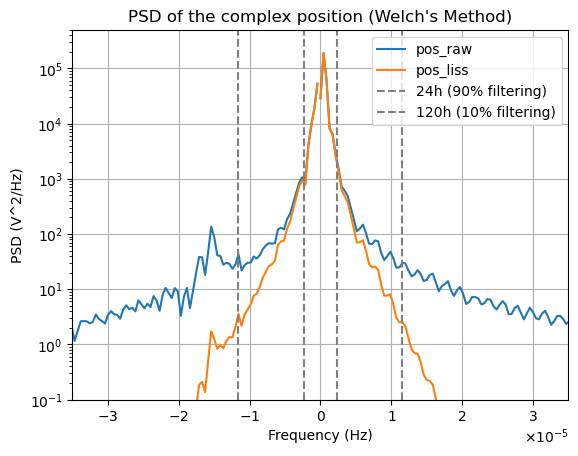

<Figure size 640x480 with 0 Axes>

In [23]:
(freq0, psd0), (freq, psd) = welch_cplx([one_trajectory.lon.values+1j*one_trajectory.lat.values, liss_lon+1j*liss_lat], ['pos_raw', 'pos_liss'], dt=one_trajectory.dt.values)

## Scipy filter

In [7]:
matplotlib.rcParams['figure.dpi'] = 300

one_trajectory = open_one_traj(L2_dir, FILES_SVP[3], idx_id= 5, L3_cleaning=True, padd_swath=0.75)

<xarray.DataArray 'dt' ()>
array(1800.)
Coordinates:
    id       <U15 '300534060112360'
    dt       float64 1.8e+03

In [6]:
sig_fil = Drifters_processing.low_pass_complex(one_trajectory.lon.values+1j*one_trajectory.lat.values, dt=one_trajectory.dt, cutoff=1/(48*3600),)

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


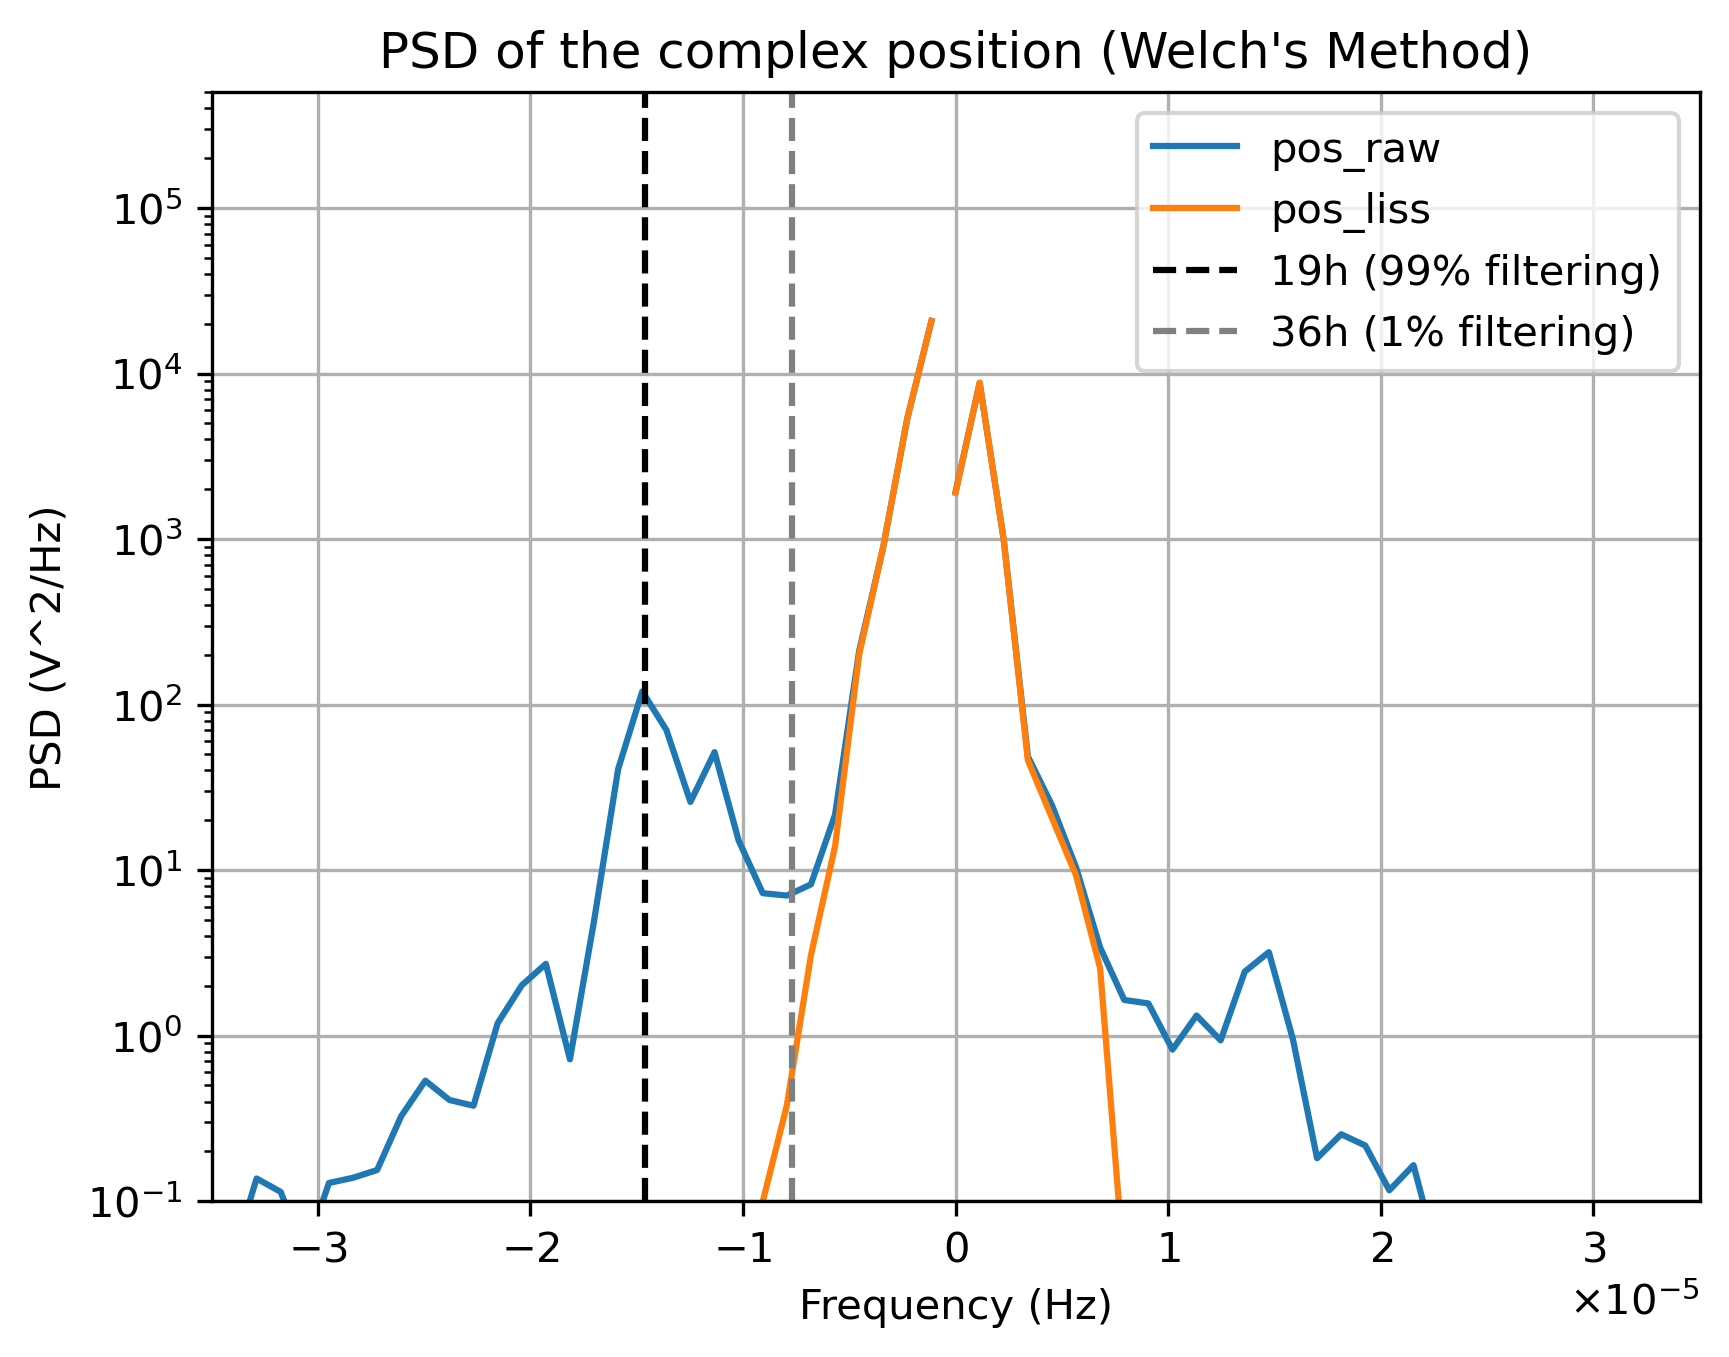

<Figure size 1920x1440 with 0 Axes>

In [222]:
(freq0, psd0), (freq, psd) = welch_cplx([one_trajectory.lon.values+1j*one_trajectory.lat.values, sig_fil], ['pos_raw', 'pos_liss'], dt=one_trajectory.dt.values)

/tmp/ipykernel_10160/610389421.py:37: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  field = field.interp(time=time_ssh)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)


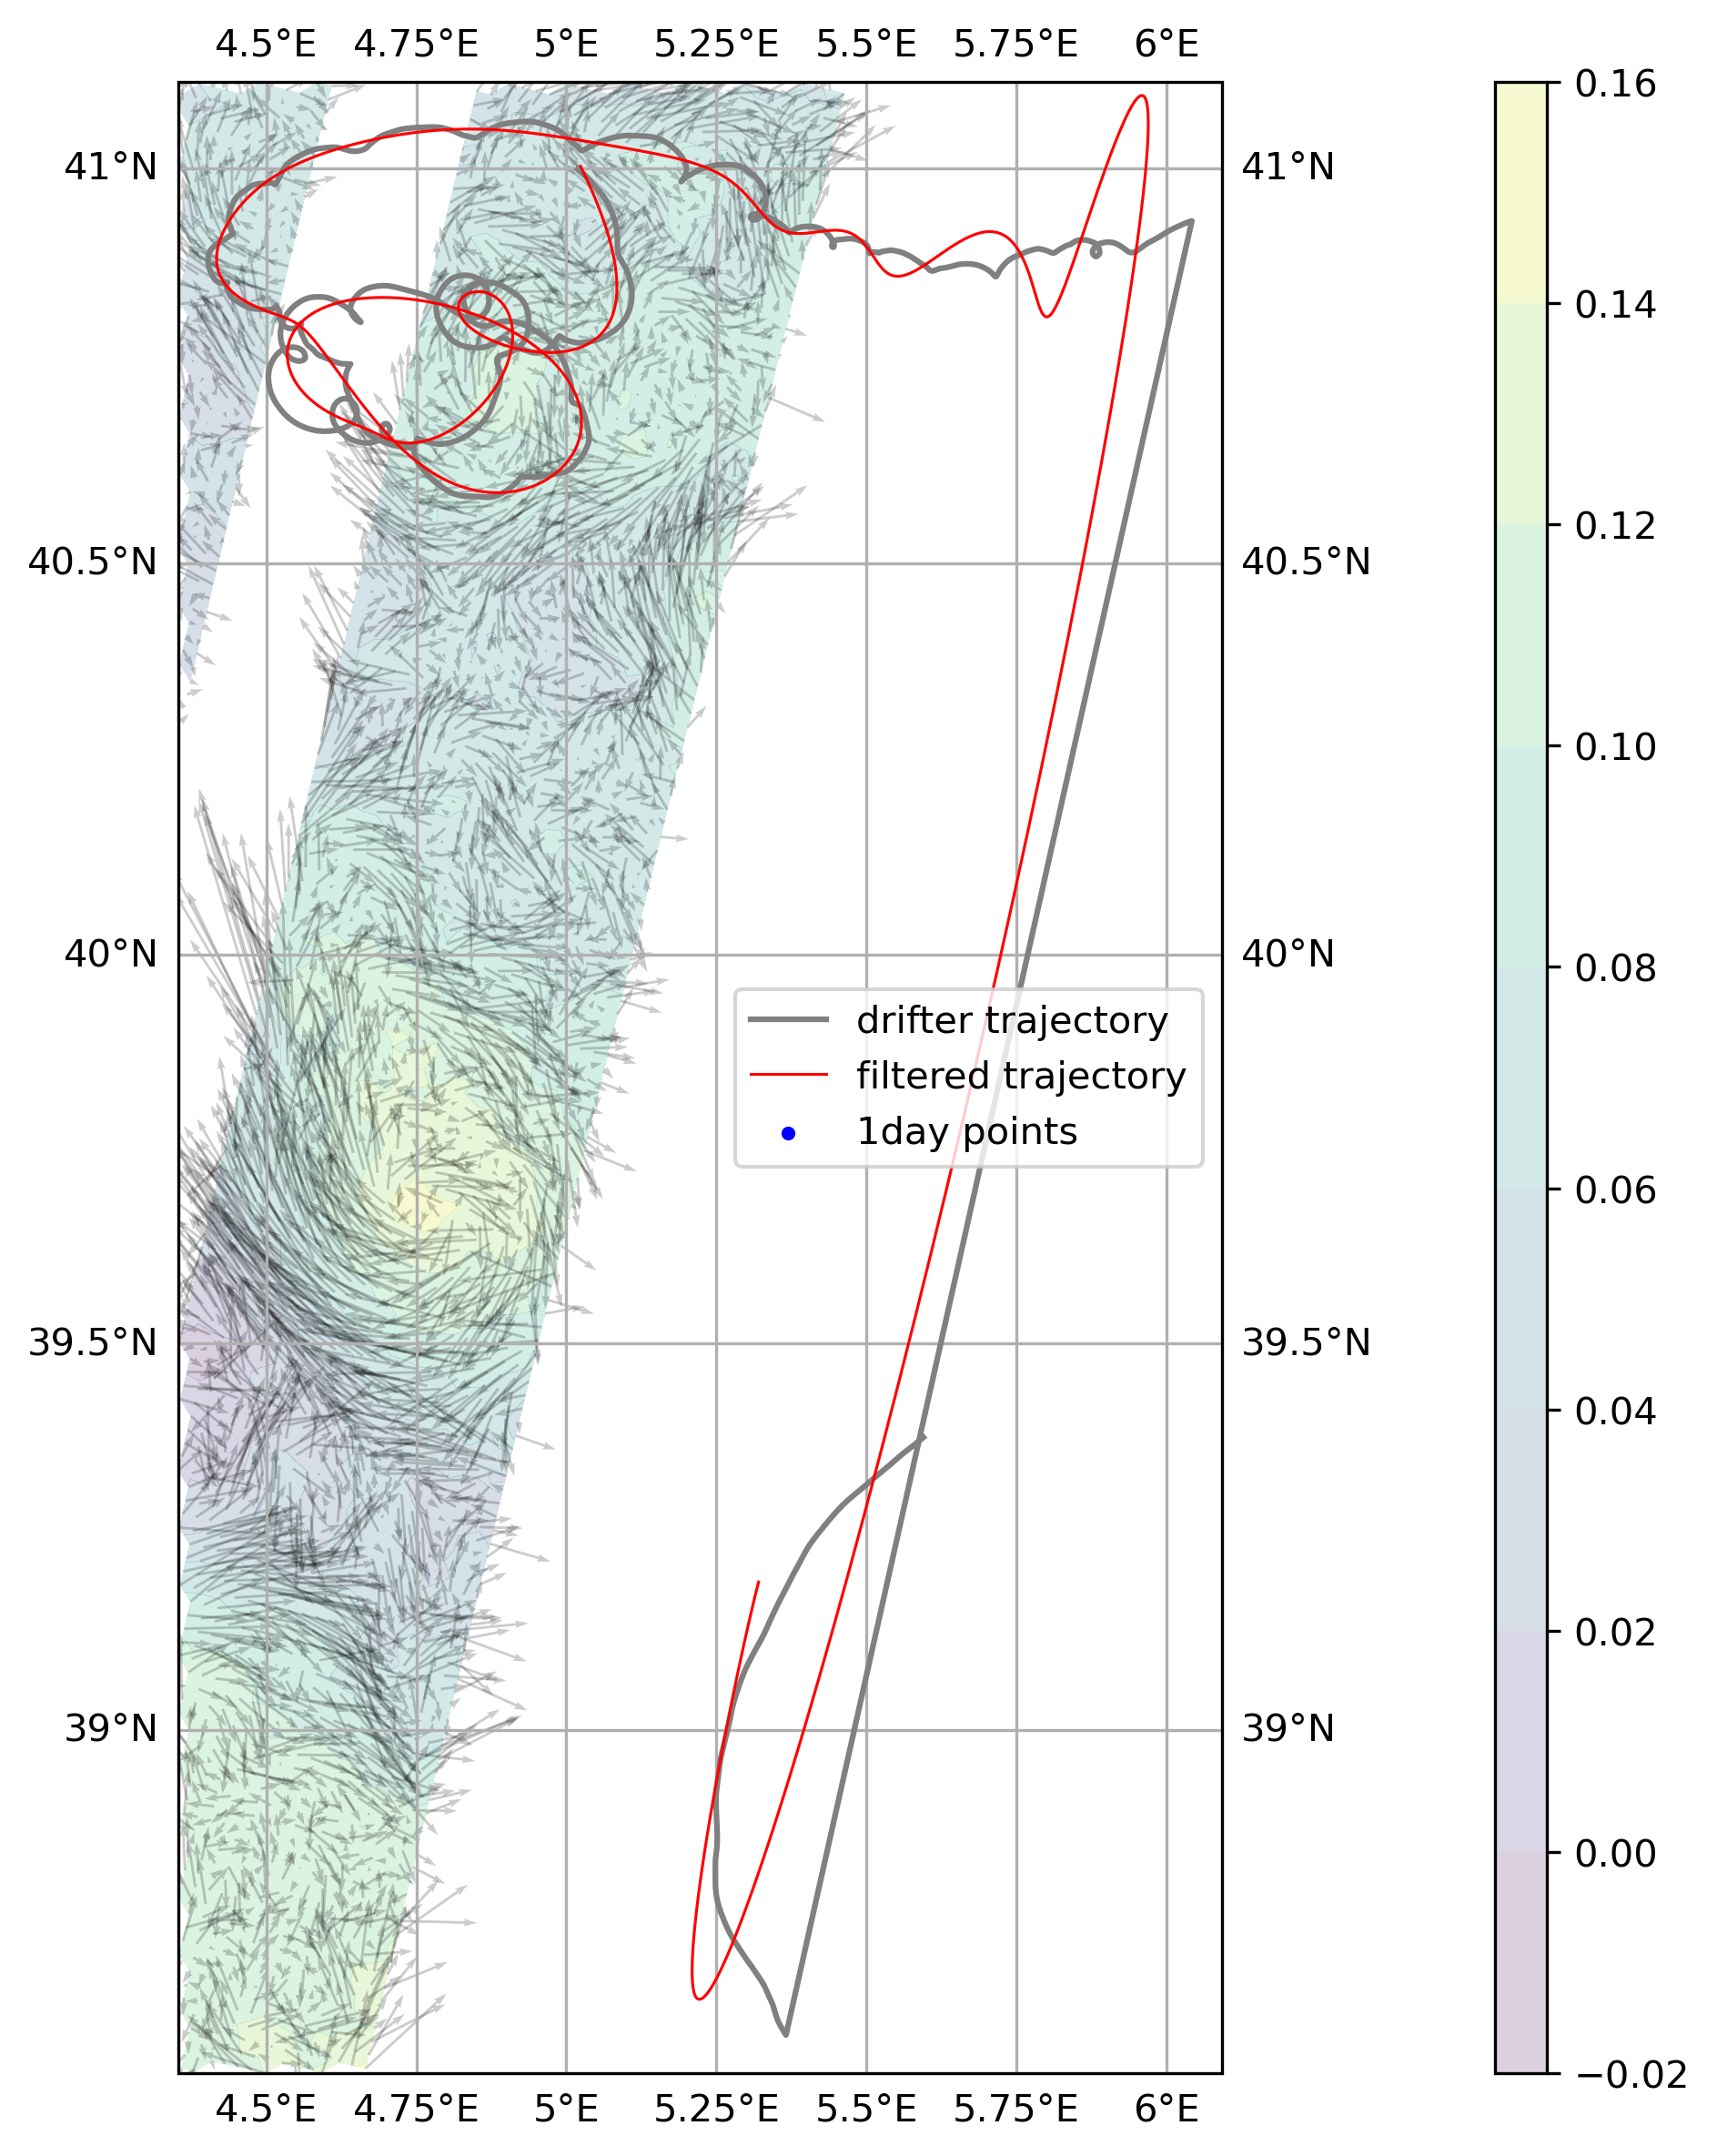

In [223]:

ds = one_trajectory

matplotlib.rcParams['figure.dpi'] = 300

plt.ion()
# Plot the trajectory with the velocity vectors AND fields vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)
scale=1.5e-5 *2
width=2.5e-3

padd = 0.05
bbox = (np.nanmin(ds.lon.values) -padd, np.nanmax(ds.lon.values) +padd, np.nanmin(ds.lat.values)-padd, np.nanmax(ds.lat.values)+padd ) 

ax.set_extent(bbox, crs=crs)

# trajectory
ax.plot(ds.lon, ds.lat,transform=crs, color='grey', label='drifter trajectory')

# filtered
ax.plot(sig_fil.real, sig_fil.imag, transform=crs, color='red', lw=0.75, label='filtered trajectory')

#points day
ax.scatter(*points_day, transform=crs, color='b', s=7, label='1day points')


# ssh field
#time_ssh = get_mean_datetime(ds.time.values)
#time_ssh = np.nanmin(ds.time.values)
time_ssh = get_mean_datetime(ds.time.values)

field = restrain_domain(ds_swot, *bbox)
field = field.interp(time=time_ssh)
ssh_field = ax.contourf(field.longitude, field.latitude, field.ssh, transform=crs, alpha=0.2, label='SSH (swot)')


# Add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1, axes_class=plt.Axes)
cbar = plt.colorbar(ssh_field, cax=cax)

# add velocity field
ax.quiver(field.longitude.values, field.latitude.values, field.u_var.values, field.v_var.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)
#ax.quiver(field.longitude.values, field.latitude.values, field.u_geos.values, field.v_geos.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)


ax.legend()

###plt.savefig(os.path.join(path_save_plots, 'filtreddrifter_gaussian_6h.png'), bbox_inches='tight', dpi = 300)